In [1]:
""" 
@author: Teodora Trandafir 
"""

' \n@author: Teodora Trandafir \n'

In [2]:
""" Update """

' Update '

#### Libraries

In [3]:
import datetime

import numpy as np 
%matplotlib inline
import math
import random

import matplotlib.pyplot as plt
import datetime
import json
import pandas as pd
import six
import csv

import os
import glob 
import sys
import shutil
from skimage import io
from scipy import misc

from PIL import Image

import tensorflow as tf
from tensorflow.python.framework import tensor_util
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.models import model_from_json, Sequential
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, EfficientNetV2B0, MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.activations import softmax, sigmoid
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator


import sklearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder


In [4]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')
print(sklearn.__version__)

2.8.0
1.1.0


2024-07-31 14:17:10.997572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-31 14:17:11.017103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-31 14:17:11.017204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
!nvidia-smi

Wed Jul 31 14:17:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   35C    P5             59W /  420W |    5692MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Session settings

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

2024-07-31 14:17:11.190646: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 14:17:11.193394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-31 14:17:11.194026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-31 14:17:11.194487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

#### Architecture settings

In [7]:
def plot_performance(figures_path, History, Exp, N_EPOCHS, foldN, runN):
    if not os.path.exists('{}/{}'.format(figures_path, Exp)):
        os.makedirs('{}/{}'.format(figures_path, Exp))
    #plt.style.use("ggplot")
    plt.figure()
    # Create two subplots and unpack the output array immediately
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False)
    
    ax1.plot(History.history["loss"], label="train_loss")
    ax1.plot(History.history["val_loss"], label="val_loss")
    ax1.set_title('Loss fold{} of run{}'.format(foldN, runN))
    ax1.set_ylabel('Loss')
    
    ax2.plot(History.history["Accuracy"], label="train_acc")
    ax2.plot(History.history["val_Accuracy"], label="val_acc")
    ax2.set_title('Accuracy fold{} of run{}'.format(foldN, runN))
    ax2.set_ylim(0,1)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlim(0, N_EPOCHS)
    ax2.set_xlabel("Epoch")
    
    plt.legend(loc="lower left")
    plt.savefig('{}/{}/Performance_fold{}{}.png'.format(figures_path, Exp, foldN, runN))
    plt.show()

#### Work directory configurations

In [8]:
print(os.getcwd())
os.chdir('..')
print(os.getcwd())

/mnt/storage/Projects/04_LCNEC/Principal
/mnt/storage/Projects/04_LCNEC


#### Location 

In [9]:
project_path = os.getcwd()

root_path = project_path + os.sep + 'Principal'
data_path = project_path + os.sep + 'LCNEC_128_Consensus'
folds_path = project_path + os.sep + 'LCNEC_128_Consensus_4folds'
save_path = project_path + os.sep + 'augument'

In [12]:
os.listdir(project_path)

['LCNEC_128_ultimate.zip',
 'Experiments',
 'Data_Archive_IHC',
 'LCNEC_128_Consensus_V11_2nd_4folds',
 'Test_LCNEC_128_Consensus_Biopsies',
 '.ipynb_checkpoints',
 'LCNEC_128_Consensus_V11',
 'SCC_masks_20x_128.zip',
 'Preprocessing',
 'Previous_attempts',
 'Preprocessing_with_masks',
 'Principal',
 'Experiments_V1',
 'Test_SCC_128',
 'Experiments_V3_V4_V5',
 'LCNEC_128_Consensus_V11_Test_2',
 'Test_LCNEC_128_Consensus_Biopsies_2',
 'LCNEC_128_Consensus_All',
 'LCNEC_128_Consensus_V11_Test',
 'Preprocessing_with_masks_2',
 'LCNEC_128_Consensus_V11_4folds',
 'Data_groups_timeline',
 'Previous_attempts_V6-V13',
 'Data_annotated_backup',
 'Experiments_V6-V13',
 'Experiments_V2']

In [14]:
# Fix seed to make training deterministic.
SEED = 3
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Input configurations 

In [15]:
""" Set data info """

DISEASE = 'LCNEC_RB_consensus4'

CLASSES = ([name for name in os.listdir(data_path)])
print(CLASSES)
N_CLASSES = len(CLASSES)
class_weights = None

GROUPS = list()
for classi in CLASSES:
    GROUPS.append([name for name in os.listdir(data_path+os.sep+classi)])
GROUPS = GROUPS[0]+GROUPS[1]
N_GROUPS = len(GROUPS) 
print(GROUPS)
print(N_GROUPS)

""" Set experiments repeats """
N_FOLDS = 4
N_RUNS = 1

""" Set model parameters """
MODEL_ARCH = 'teonet_u2'
LOSS_FUNC = 'BBCE'
N_EPOCHS = 50
PATIENCE = 20
PATCH_SIZE =128
DOWNSIZING_FACTOR = 1 # 1 for original image size
PATCH_SIZE = int(PATCH_SIZE/DOWNSIZING_FACTOR) # both height and width
BATCH_SIZE = 128 * DOWNSIZING_FACTOR * DOWNSIZING_FACTOR
LR = 1e-4
""" Set randomization parameters """
SHUFFLE = True

""" Set required metrics evaluation """
METRICS = ["Accuracy"]
#METRICS = [tf.keras.metrics.CategoricalAccuracy()]

""" Set annalysed fold """
foldN = 1
runN = 1

['1', '0']
['T12-21028', 'T04-29612', 'T06-1349', 'T10-14994', 'T09-20292', 'H23-26063', 'T12-23176', 'T08-07800', 'T09-21310', 'T06-36014', 'T12-025063', 'H21-2643', 'T21-19855', 'T11-15693', 'T10-17506', 'H22-7537', 'T06-15230', 'H21-11135', 'H20-7575', 'T12-1775', 'T11-018111', 'T10-02288', 'H20-28675', 'T12-42525', 'T09-020872', 'T09-25062', 'T09-15595', 'T11-22093', 'T10-17366', 'T08-18308', 'H22-8273', 'T05-43721', 'T12-13076', 'T06-9449', 'T03-8591', 'H21-11779', 'T11-3650', 'T11-004315', 'T21-4052', 'T04-16007', 'T11-37240', 'T05-14627', 'H21-5375', 'H23-3028', 'T09-11669', 'T13-03603', 'T04-38007', 'T11-6577', 'T04-027776', 'T11-6270', 'T10-17446', 'T10-00479', 'T09-3755', 'T09-12936', 'T09-21445', 'T12-9652', 'T06-014185', 'T12-26370', 'T03-063718', 'T11-07048', 'T12-31705', 'T11-22476', 'T09-14771', 'T12-05753', 'T05-9503', 'T12-13417', 'T07-15708', 'T10-1165', 'T09-20053', 'H22-2962', 'T05-28359', 'T12-5564', 'T04-6242', 'T09-35169', 'T12-05670', 'T11-37218', 'T10-11697', '

In [16]:
""" Set required functions """

OPTIMIZER = keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=LR*0.1, amsgrad=True, name='Adam')

LOSS = BinaryCrossentropy()

In [17]:
""" Set experiment name """

Exp = DISEASE+'_'+MODEL_ARCH+'_'+LOSS_FUNC+'_'+str(N_CLASSES)+'_'+str(PATCH_SIZE)

In [18]:
""" Pretrained weights """

pretrained_weights = None
print(pretrained_weights)

None


In [19]:
""" Output locations"""

history_path = '{}/Experiments/{}/history_data'.format(project_path, Exp)
weights_path = '{}/Experiments/{}/weights_data'.format(project_path, Exp)
figures_path = '{}/Experiments/{}/figures_data'.format(project_path, Exp)

In [20]:
# """ Check initial numbers """
# for subdirs, dirs, files in os.walk(folds_path):
#     print(subdirs, "has ", len(os.listdir(subdirs)), " elements")

#### Preprocessing function

In [21]:
def rotate_image(image):
    return np.rot90(image, np.random.choice([0, 1, 2, 3]))

#### Generator setup

In [22]:
""" Augmentation/preprocessing setup for training and validation data generator """

augmentation_arguments_train = dict(featurewise_center=False,
                                    samplewise_center = False,
                                    featurewise_std_normalization = False,
                                    samplewise_std_normalization = False,
                                    rotation_range = None,
                                    brightness_range = None,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    rescale = 1./255.,
                                    # fill_mode = "constant",
                                    # cval = 255.0,
                                    preprocessing_function = rotate_image) #tf.keras.applications.resnet_v2.preprocess_input)

augmentation_arguments_valid = dict(featurewise_center = False,
                                    samplewise_center = False,
                                    featurewise_std_normalization = False,
                                    samplewise_std_normalization = False,
                                    rotation_range = None,
                                    brightness_range = None,
                                    horizontal_flip = False,
                                    vertical_flip = False,
                                    rescale = 1./255.,
                                    # fill_mode = "constant",
                                    # cval = 255.0,
                                    preprocessing_function = None) #tf.keras.applications.resnet_v2.preprocess_input)

#### Training

In [23]:
"""-------------------- Data generator --------------------""" 

train_path = '{}/Fold{}{}/Train/'.format(folds_path, foldN, runN)
valid_path = '{}/Fold{}{}/Validation/'.format(folds_path, foldN, runN)


"""--------------------- Generate batches of tiles from train and validation set of this fold ---------------------"""
train_datagen = ImageDataGenerator(**augmentation_arguments_train).flow_from_directory(directory = train_path, 
                                                                                        batch_size = BATCH_SIZE, 
                                                                                        target_size = (PATCH_SIZE,PATCH_SIZE),
                                                                                        color_mode = "rgb",
                                                                                        class_mode = "binary", 
                                                                                        #classes = CLASSES,
                                                                                        seed = SEED,
                                                                                        shuffle = True,
                                                                                        #save_to_dir = save_path
                                                                                      )

valid_datagen = ImageDataGenerator(**augmentation_arguments_valid).flow_from_directory(directory = valid_path,
                                                                                        batch_size = BATCH_SIZE, 
                                                                                        target_size = (PATCH_SIZE,PATCH_SIZE),
                                                                                        color_mode= "rgb",
                                                                                        class_mode = "binary", 
                                                                                        #classes = CLASSES,
                                                                                        seed= SEED,
                                                                                        shuffle = False)

       

Found 20559 images belonging to 2 classes.
Found 6935 images belonging to 2 classes.


In [24]:
train_datagen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [25]:
np.unique(train_datagen.classes)

array([0, 1], dtype=int32)

In [27]:
"""--------------------- Calculate number of tiles in train and validation set ---------------------"""    

n_train_samples, n_validation_samples = 0, 0
for classi in CLASSES:
    for sample in os.listdir('{}/{}'.format(train_path, classi)):
         n_train_samples += len(os.listdir('{}/{}/{}'.format(train_path, classi, sample)))
    for sample in os.listdir('{}/{}'.format(valid_path, classi)):        
        n_validation_samples += len(os.listdir('{}/{}/{}'.format(valid_path, classi, sample)))
    
print(n_train_samples)
print(n_validation_samples)

20559
6935


In [28]:
"""--------------------- Set model weigths location ---------------------"""

if not os.path.exists('{}/Fold{}{}'.format(weights_path, foldN, runN)):
    os.makedirs('{}/Fold{}{}'.format(weights_path, foldN, runN))
model_weights = '{}/Fold{}{}/Weights_{}_{}{}_'.format(weights_path, foldN, runN, Exp, foldN, runN)
model_weights = model_weights + '{epoch:02d}_{val_loss:.2f}.hdf5' 
csv_log = model_weights + '.csv' 
# if not os.path.exists(model_weights):
#     with open(model_weights, 'w'): pass

In [29]:
"""--------------------- Set callbacks ---------------------"""

model_checkpoint = ModelCheckpoint(model_weights, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq = "epoch")
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=0, min_lr=1e-7)
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = PATIENCE, verbose = 1, mode = 'auto')
cvs_logger = CSVLogger(csv_log, separator=',', append=False)

In [30]:
"""-------------------- Fit model --------------------"""

from model_u2 import *

model = create_binary_classification_model(input_shape=(PATCH_SIZE, PATCH_SIZE, 3))

model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

# Summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 64)        3

2024-07-31 14:17:11.862787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-31 14:17:11.862976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-31 14:17:11.863056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-31 14:17:11.863164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-31 14:17:11.863241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [31]:
"""-------------------- Calculate the weights for each class so that we can balance the data --------------------"""

class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_datagen.classes), y = train_datagen.classes)
class_weights = dict(zip(np.unique(train_datagen.classes), class_weights))
class_weights

{0: 0.9108994240141781, 1: 1.1084213931421179}

In [32]:
"""-------------------- Train model --------------------"""

with tf.device('/gpu:0'):
    history = model.fit(train_datagen,          
                    steps_per_epoch = math.floor(n_train_samples/BATCH_SIZE),
                    epochs = N_EPOCHS,
                    class_weight= class_weights,
                    validation_data = valid_datagen,
                    shuffle = True,
                    callbacks = [model_checkpoint, earlystop, cvs_logger],#reduce_lr
                    validation_steps = math.floor(n_validation_samples/BATCH_SIZE))

Epoch 1/50


2024-07-31 14:17:12.974167: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-07-31 14:17:14.313309: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


160/160 [==============================] - ETA: 0s - loss: 3.5115 - Accuracy: 0.6868
Epoch 1: val_loss improved from inf to 3.55007, saving model to /mnt/storage/Projects/04_LCNEC/Experiments/LCNEC_RB_consensus4_V11_teonet_u3_BBCE_2_128/weights_data/Fold41/Weights_LCNEC_RB_consensus4_V11_teonet_u3_BBCE_2_128_41_01_3.55.hdf5
160/160 [==============================] - 13s 65ms/step - loss: 3.5115 - Accuracy: 0.6868 - val_loss: 3.5501 - val_Accuracy: 0.5618
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 3.1686 - Accuracy: 0.7349
Epoch 2: val_loss improved from 3.55007 to 3.34093, saving model to /mnt/storage/Projects/04_LCNEC/Experiments/LCNEC_RB_consensus4_V11_teonet_u3_BBCE_2_128/weights_data/Fold41/Weights_LCNEC_RB_consensus4_V11_teonet_u3_BBCE_2_128_41_02_3.34.hdf5
160/160 [==============================] - 10s 61ms/step - loss: 3.1686 - Accuracy: 0.7349 - val_loss: 3.3409 - val_Accuracy: 0.6657
Epoch 3/50
159/160 [============================>.] - ETA: 0s - los

In [33]:
"""-------------------- Save the weights in the current directory --------------------"""  

#for i, w in enumerate(model.weights): print(i, w.name) 
model.save_weights(model_weights)
print("Weights saved")

Weights saved


<Figure size 432x288 with 0 Axes>

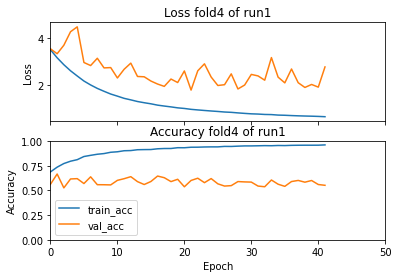

In [34]:
"""-------------------- Plot the model history --------------------"""

plot_performance(figures_path, history, Exp, N_EPOCHS, foldN, runN)
K.clear_session()
%reset -f

In [35]:
"""Clear session cashe"""

from keras import backend as K 
K.clear_session()
%reset -f

In [36]:
#!reboot

#### 